In [138]:
import arviz as az
import os.path as op
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [139]:
session = '3t2'
bids_folder = '/data/ds-risk'

In [140]:
risk_preferences = pd.read_csv(op.join(bids_folder, 'derivatives', 'cogmodels', 'simple_risk_preference.tsv'), index_col=[0, 1], sep='\t')

In [141]:
idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'ses-{session}_model-1_trace.netcdf'))

In [142]:
sns.set_theme('paper', 'white', font='helvetica', font_scale=1.25, palette='tab10')

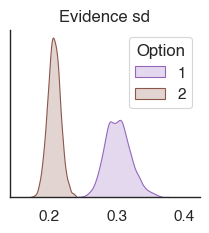

In [143]:
evidence_sd = pd.concat((idata.posterior['n1_evidence_sd_mu'].to_dataframe(), (idata.posterior['n2_evidence_sd_mu'].to_dataframe())), axis=1)
evidence_sd.columns.name = 'parameter'
evidence_sd = evidence_sd.stack().to_frame('value')
evidence_sd['Option'] = evidence_sd.index.get_level_values('parameter').map({'n1_evidence_sd_mu':1, 'n2_evidence_sd_mu':2})

fac = sns.FacetGrid(evidence_sd.reset_index(), hue='Option', palette=sns.color_palette()[4:], aspect=1.1, height=2.5)
fac.map(sns.kdeplot, 'value', fill=True)
fac.set(xlabel=None, ylabel=None, yticks=[])
plt.title('Evidence sd')
# fac.add_legend()
plt.legend(title='Option')

plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-3t2_evidence_sd.pdf'), bbox_inches='tight')

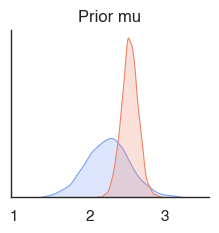

In [144]:
palette = sns.color_palette('coolwarm', 4)
palette = [palette[ix] for ix in [0, 3]]

evidence_sd = pd.concat((idata.posterior['risky_prior_mu_mu'].to_dataframe(), (idata.posterior['safe_prior_mu_mu'].to_dataframe())), axis=1)
evidence_sd.columns.name = 'parameter'
evidence_sd = evidence_sd.stack().to_frame('value')
evidence_sd['Option'] = evidence_sd.index.get_level_values('parameter').map({'risky_prior_mu_mu':'Risky', 'safe_prior_mu_mu':'Safe'})

fac = sns.FacetGrid(evidence_sd.reset_index(), hue='Option', palette=palette, aspect=1.1, height=2.5, hue_order=['Safe', 'Risky'])
fac.map(sns.kdeplot, 'value', fill=True)
fac.set(xlabel=None, ylabel=None, yticks=[])
plt.title('Prior mu')
# fac.add_legend()
# plt.legend(title='Option')

plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-3t2_prior_mu.pdf'), bbox_inches='tight')

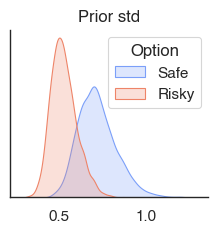

In [145]:
palette = sns.color_palette('coolwarm', 4)
palette = [palette[ix] for ix in [0, 3]]

evidence_sd = pd.concat((idata.posterior['risky_prior_std_mu'].to_dataframe(), (idata.posterior['safe_prior_std_mu'].to_dataframe())), axis=1)
evidence_sd.columns.name = 'parameter'
evidence_sd = evidence_sd.stack().to_frame('value')
evidence_sd['Option'] = evidence_sd.index.get_level_values('parameter').map({'risky_prior_std_mu':'Risky', 'safe_prior_std_mu':'Safe'})

fac = sns.FacetGrid(evidence_sd.reset_index(), hue='Option', palette=palette, aspect=1.1, height=2.5, hue_order=['Safe', 'Risky'])
fac.map(sns.kdeplot, 'value', fill=True)
fac.set(xlabel=None, ylabel=None, yticks=[])
plt.title('Prior std')
# fac.add_legend()
plt.legend(title='Option')
plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-3t2_prior_std.pdf'), bbox_inches='tight')

In [166]:
colors = {'risk-neutral':'k', 'risk-seeking':sns.color_palette('Spectral', 3)[0], 
          'risk-averse':sns.color_palette('Spectral', 3)[-1]}

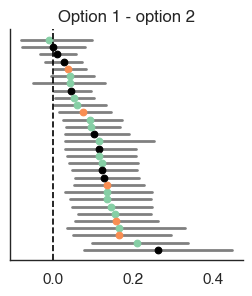

In [167]:
tmp = pd.concat((idata.posterior['n1_evidence_sd'].to_dataframe(), idata.posterior['n2_evidence_sd'].to_dataframe()), axis=1)

diff = (tmp['n1_evidence_sd'] - tmp['n2_evidence_sd']).to_frame('Evidence sd 1 - evidence sd 2')
# sns.catplot(data=diff, x='subject', y='Evidence sd 1 - evidence sd 2')

hdi = diff.groupby('subject').apply(lambda d: pd.Series(az.hdi(d.values[:, 0]), index=['low', 'high']))

mean = diff.groupby("subject").mean()
mean.columns = ['mean']

tmp = mean.join(hdi)
tmp = tmp.join(risk_preferences.xs(session, 0, 'session'))

order = mean.sort_values('mean').index.tolist()

def plot_hdi(data, *args, **kwargs):
    for ix, row in data.iterrows():
        x = order.index(ix)
        plt.scatter([row['mean']], [-x], marker='o', color=colors[row.risk_profile], zorder=5,)
        plt.plot([row['low'], row['high']], [-x, -x], color='gray', lw=2)

plot_hdi(tmp)
# plt.axis('off')
sns.despine()
plt.yticks([])
plt.axvline(0, c='k', ls='--', zorder=10)
plt.gcf().set_size_inches(3, 3)
plt.title('Option 1 - option 2')
plt.savefig('/data/ds-risk/derivatives/figures/3t2_evidence_sd_diff.pdf', bbox_inches='tight')

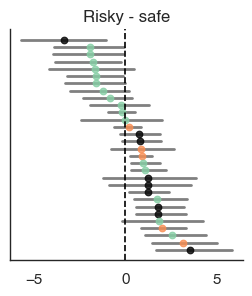

In [168]:
tmp = pd.concat((idata.posterior['risky_prior_mu'].to_dataframe(), idata.posterior['safe_prior_mu'].to_dataframe()), axis=1)

diff = (tmp['risky_prior_mu'] - tmp['safe_prior_mu']).to_frame('diff')
# sns.catplot(data=diff, x='subject', y='Evidence sd 1 - evidence sd 2')

hdi = diff.groupby('subject').apply(lambda d: pd.Series(az.hdi(d.values[:, 0]), index=['low', 'high']))

mean = diff.groupby("subject").mean()
mean.columns = ['mean']

tmp = mean.join(hdi)

tmp = tmp.join(risk_preferences.xs(session, 0, 'session'))

order = mean.sort_values('mean').index.tolist()

def plot_hdi(data, *args, **kwargs):
    for ix, row in data.iterrows():
        x = order.index(ix)
        plt.scatter([row['mean']], [-x], marker='o', color=colors[row.risk_profile], zorder=5, alpha=.8)
        plt.plot([row['low'], row['high']], [-x, -x], color='gray', lw=2)

plot_hdi(tmp)
# plt.axis('off')
sns.despine()
plt.yticks([])
plt.axvline(0, c='k', ls='--', zorder=10)
plt.gcf().set_size_inches(3, 3)
plt.title('Risky - safe')

plt.savefig('/data/ds-risk/derivatives/figures/3t2_risky_prior_mu_diff.pdf', bbox_inches='tight')

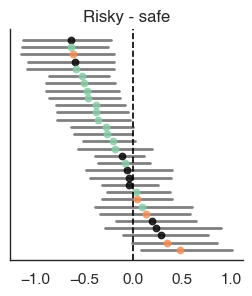

In [169]:
tmp = pd.concat((idata.posterior['risky_prior_std'].to_dataframe(), idata.posterior['safe_prior_std'].to_dataframe()), axis=1)

diff = (tmp['risky_prior_std'] - tmp['safe_prior_std']).to_frame('diff')
# sns.catplot(data=diff, x='subject', y='Evidence sd 1 - evidence sd 2')

hdi = diff.groupby('subject').apply(lambda d: pd.Series(az.hdi(d.values[:, 0]), index=['low', 'high']))

mean = diff.groupby("subject").mean()
mean.columns = ['mean']

tmp = mean.join(hdi)
tmp = tmp.join(risk_preferences.xs(session, 0, 'session'))

order = mean.sort_values('mean').index.tolist()

def plot_hdi(data, *args, **kwargs):
    for ix, row in data.iterrows():
        x = order.index(ix)
        plt.scatter([row['mean']], [-x], marker='o', color=colors[row.risk_profile], zorder=5, alpha=.8)
        plt.plot([row['low'], row['high']], [-x, -x], color='gray', lw=2)

plot_hdi(tmp)
# plt.axis('off')
sns.despine()
plt.yticks([])
plt.axvline(0, c='k', ls='--', zorder=10)
plt.gcf().set_size_inches(3, 3)
plt.gcf().set_size_inches(3, 3)
plt.title('Risky - safe')

plt.savefig('/data/ds-risk/derivatives/figures/3t2_risky_prior_std_diff.pdf', bbox_inches='tight')

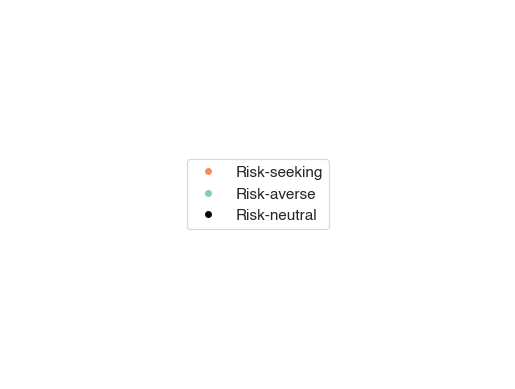

In [191]:
from matplotlib.lines import Line2D

fig = plt.gcf()

legend_elements = [Line2D([0], [0], markerfacecolor=colors['risk-seeking'], marker='o', color='w', label='Risk-seeking', markersize=6),
                   Line2D([0], [0], markerfacecolor=colors['risk-averse'], marker='o', color='w', label='Risk-averse', markersize=6),
                   Line2D([0], [0], markerfacecolor=colors['risk-neutral'], marker='o', color='w', label='Risk-neutral', markersize=6),]


legend = plt.legend(handles=legend_elements, loc='center')
plt.axis('off')

bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# fig.savefig(filename, dpi="figure", bbox_inches=bbox)

plt.savefig('/data/ds-risk/derivatives/figures/risky_legend.pdf', bbox_inches=bbox)

In [182]:
session = '7t2'


idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'ses-{session}_model-1_trace.netcdf'))

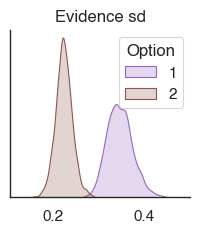

In [183]:
evidence_sd = pd.concat((idata.posterior['n1_evidence_sd_mu'].to_dataframe(), (idata.posterior['n2_evidence_sd_mu'].to_dataframe())), axis=1)
evidence_sd.columns.name = 'parameter'
evidence_sd = evidence_sd.stack().to_frame('value')
evidence_sd['Option'] = evidence_sd.index.get_level_values('parameter').map({'n1_evidence_sd_mu':1, 'n2_evidence_sd_mu':2})

fac = sns.FacetGrid(evidence_sd.reset_index(), hue='Option', palette=sns.color_palette()[4:], aspect=1.1, height=2.5)
fac.map(sns.kdeplot, 'value', fill=True)
fac.set(xlabel=None, ylabel=None, yticks=[])
plt.title('Evidence sd')
# fac.add_legend()
plt.legend(title='Option')

plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-7t2_evidence_sd.pdf'), bbox_inches='tight')

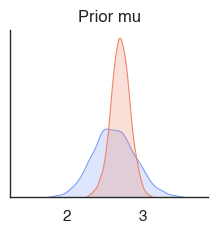

In [184]:
palette = sns.color_palette('coolwarm', 4)
palette = [palette[ix] for ix in [0, 3]]

evidence_sd = pd.concat((idata.posterior['risky_prior_mu_mu'].to_dataframe(), (idata.posterior['safe_prior_mu_mu'].to_dataframe())), axis=1)
evidence_sd.columns.name = 'parameter'
evidence_sd = evidence_sd.stack().to_frame('value')
evidence_sd['Option'] = evidence_sd.index.get_level_values('parameter').map({'risky_prior_mu_mu':'Risky', 'safe_prior_mu_mu':'Safe'})

fac = sns.FacetGrid(evidence_sd.reset_index(), hue='Option', palette=palette, aspect=1.1, height=2.5, hue_order=['Safe', 'Risky'])
fac.map(sns.kdeplot, 'value', fill=True)
fac.set(xlabel=None, ylabel=None, yticks=[])
plt.title('Prior mu')
# fac.add_legend()
# plt.legend(title='Option')

plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-7t2_prior_mu.pdf'), bbox_inches='tight')

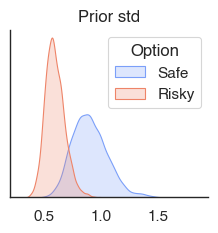

In [185]:
palette = sns.color_palette('coolwarm', 4)
palette = [palette[ix] for ix in [0, 3]]

evidence_sd = pd.concat((idata.posterior['risky_prior_std_mu'].to_dataframe(), (idata.posterior['safe_prior_std_mu'].to_dataframe())), axis=1)
evidence_sd.columns.name = 'parameter'
evidence_sd = evidence_sd.stack().to_frame('value')
evidence_sd['Option'] = evidence_sd.index.get_level_values('parameter').map({'risky_prior_std_mu':'Risky', 'safe_prior_std_mu':'Safe'})

fac = sns.FacetGrid(evidence_sd.reset_index(), hue='Option', palette=palette, aspect=1.1, height=2.5, hue_order=['Safe', 'Risky'])
fac.map(sns.kdeplot, 'value', fill=True)
fac.set(xlabel=None, ylabel=None, yticks=[])
plt.title('Prior std')
# fac.add_legend()
plt.legend(title='Option')
plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-7t2_prior_std.pdf'), bbox_inches='tight')

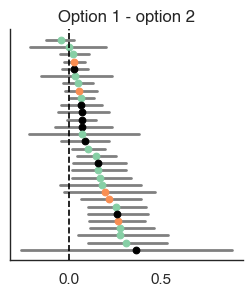

In [186]:
tmp = pd.concat((idata.posterior['n1_evidence_sd'].to_dataframe(), idata.posterior['n2_evidence_sd'].to_dataframe()), axis=1)

diff = (tmp['n1_evidence_sd'] - tmp['n2_evidence_sd']).to_frame('Evidence sd 1 - evidence sd 2')
# sns.catplot(data=diff, x='subject', y='Evidence sd 1 - evidence sd 2')

hdi = diff.groupby('subject').apply(lambda d: pd.Series(az.hdi(d.values[:, 0]), index=['low', 'high']))

mean = diff.groupby("subject").mean()
mean.columns = ['mean']

tmp = mean.join(hdi)
tmp = tmp.join(risk_preferences.xs(session, 0, 'session'))

order = mean.sort_values('mean').index.tolist()

def plot_hdi(data, *args, **kwargs):
    for ix, row in data.iterrows():
        x = order.index(ix)
        plt.scatter([row['mean']], [-x], marker='o', color=colors[row.risk_profile], zorder=5,)
        plt.plot([row['low'], row['high']], [-x, -x], color='gray', lw=2)

plot_hdi(tmp)
# plt.axis('off')
sns.despine()
plt.yticks([])
plt.axvline(0, c='k', ls='--', zorder=10)
plt.gcf().set_size_inches(3, 3)
plt.title('Option 1 - option 2')
plt.savefig('/data/ds-risk/derivatives/figures/7t2_evidence_sd_diff.pdf', bbox_inches='tight')

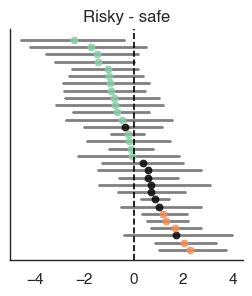

In [187]:
tmp = pd.concat((idata.posterior['risky_prior_mu'].to_dataframe(), idata.posterior['safe_prior_mu'].to_dataframe()), axis=1)

diff = (tmp['risky_prior_mu'] - tmp['safe_prior_mu']).to_frame('diff')
# sns.catplot(data=diff, x='subject', y='Evidence sd 1 - evidence sd 2')

hdi = diff.groupby('subject').apply(lambda d: pd.Series(az.hdi(d.values[:, 0]), index=['low', 'high']))

mean = diff.groupby("subject").mean()
mean.columns = ['mean']

tmp = mean.join(hdi)

tmp = tmp.join(risk_preferences.xs(session, 0, 'session'))

order = mean.sort_values('mean').index.tolist()

def plot_hdi(data, *args, **kwargs):
    for ix, row in data.iterrows():
        x = order.index(ix)
        plt.scatter([row['mean']], [-x], marker='o', color=colors[row.risk_profile], zorder=5, alpha=.8)
        plt.plot([row['low'], row['high']], [-x, -x], color='gray', lw=2)

plot_hdi(tmp)
# plt.axis('off')
sns.despine()
plt.yticks([])
plt.axvline(0, c='k', ls='--', zorder=10)
plt.gcf().set_size_inches(3, 3)
plt.title('Risky - safe')

plt.savefig('/data/ds-risk/derivatives/figures/7t2_risky_prior_mu_diff.pdf', bbox_inches='tight')

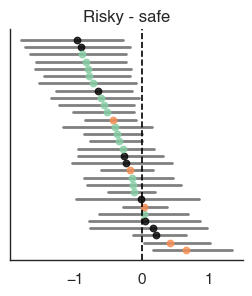

In [188]:
tmp = pd.concat((idata.posterior['risky_prior_std'].to_dataframe(), idata.posterior['safe_prior_std'].to_dataframe()), axis=1)

diff = (tmp['risky_prior_std'] - tmp['safe_prior_std']).to_frame('diff')
# sns.catplot(data=diff, x='subject', y='Evidence sd 1 - evidence sd 2')

hdi = diff.groupby('subject').apply(lambda d: pd.Series(az.hdi(d.values[:, 0]), index=['low', 'high']))

mean = diff.groupby("subject").mean()
mean.columns = ['mean']

tmp = mean.join(hdi)
tmp = tmp.join(risk_preferences.xs(session, 0, 'session'))

order = mean.sort_values('mean').index.tolist()

def plot_hdi(data, *args, **kwargs):
    for ix, row in data.iterrows():
        x = order.index(ix)
        plt.scatter([row['mean']], [-x], marker='o', color=colors[row.risk_profile], zorder=5, alpha=.8)
        plt.plot([row['low'], row['high']], [-x, -x], color='gray', lw=2)

plot_hdi(tmp)
# plt.axis('off')
sns.despine()
plt.yticks([])
plt.axvline(0, c='k', ls='--', zorder=10)
plt.gcf().set_size_inches(3, 3)
plt.gcf().set_size_inches(3, 3)
plt.title('Risky - safe')

plt.savefig('/data/ds-risk/derivatives/figures/7t2_risky_prior_std_diff.pdf', bbox_inches='tight')

In [193]:
import numpy as np
risky_n = np.where(df['risky_first'], df['n1'], df['n2'])
safe_n = np.where(df['risky_first'], df['n2'], df['n1'])

In [195]:
risky_prior_mu = np.mean(np.log(risky_n))
risky_prior_std = np.std(np.log(risky_n))

safe_prior_mu = np.mean(np.log(safe_n))
safe_prior_std = np.std(np.log(safe_n))

In [198]:
import aesara.tensor as at

In [202]:
risky_prior_mu, at.softplus(risky_prior_mu).eval()

(3.18566706924126, array(3.22618564))

In [203]:
risky_prior_std, at.softplus(risky_prior_std).eval()

(0.7032985052770899, array(1.10539128))

In [204]:
safe_prior_mu, at.softplus(safe_prior_mu).eval()

(2.470821211304652, array(2.55195449))

In [205]:
safe_prior_std, at.softplus(safe_prior_std).eval()

(0.5904281503985234, array(1.03131832))